## This script is to convert recorded demonstrations (from rosbag format) to samples (in txt format) to conform with the TP-GMM code.

In [1]:
import rosbag
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sys import platform

# from franka_msgs.msg import FrankaState

print(platform)
if platform == "linux":
    main_dir = "/home/erl/Multicobot-UR10/src/motion_planning/bag_files/Trajectory_Data_Collection/Demons/"
    TPGMM_dir = "/home/erl/Multicobot-UR10/src/tp_gmm/data/"
elif platform == "win32":
    main_dir = "C:/Users/AWasf/OneDrive/Desktop/PhD Lab Work/Disassembly-Teleop/"
    TPGMM_dir = "C:/Users/AWasf/OneDrive/Desktop/PhD Lab Work/tp_gmm/data/"


linux


### Defining the directory according to the given task_name, and thus loop over the Demons in the directory (task_name, nbDemons in dir, ref_demon)

In [2]:
# Getting the task_name from tp-gmm.py
import pickle

with open('/home/erl/Multicobot-UR10/src/tp_gmm/scripts/demons_info1.pkl', 'rb') as fp:
    demons_info = pickle.load(fp)
    print(demons_info)
task_name = demons_info['task_name']
print("task_name: ", task_name)

# 
import os

demons_names = []
demons_nums = []
for filename in os.listdir(main_dir):
    demons_names.append(filename)
    demons_nums.append(filename[filename.find('demon'):filename.find('.bag')])

print(demons_names)
print(demons_nums)

nbdemons = len(demons_names)
print("Number of Demons: ", nbdemons)


{'task_name': 'Rbolts'}
task_name:  Rbolts
['demon_2.bag', 'demon_1.bag', 'demon_14.bag', 'demon_44.bag', 'demon_32.bag', 'demon_26.bag', 'demon_10.bag', 'demon_28.bag', 'demon_21.bag', 'demon_15.bag', 'demon_20.bag', 'demon_38.bag', 'demon_48.bag', 'demon_46.bag', 'demon_27.bag', 'demon_45.bag', 'demon_37.bag', 'demon_13.bag', 'demon_3.bag', 'demon_18.bag', 'demon_12.bag', 'demon_22.bag', 'demon_16.bag', 'demon_25.bag', 'demon_8.bag', 'demon_17.bag', 'demon_24.bag', 'demon_42.bag', 'demon_23.bag', 'demon_9.bag', 'demon_39.bag', 'demon_5.bag', 'demon_33.bag', 'demon_34.bag', 'demon_35.bag', 'demon_4.bag', 'demon_47.bag', 'demon_6.bag', 'demon_40.bag', 'demon_43.bag', 'demon_30.bag', 'demon_19.bag', 'demon_49.bag', 'demon_50.bag', 'demon_31.bag', 'demon_11.bag', 'demon_29.bag', 'demon_41.bag', 'demon_36.bag', 'demon_7.bag']
['demon_2', 'demon_1', 'demon_14', 'demon_44', 'demon_32', 'demon_26', 'demon_10', 'demon_28', 'demon_21', 'demon_15', 'demon_20', 'demon_38', 'demon_48', 'demon_46'

### 3D

In [3]:
from geometry_msgs.msg import Pose, PoseArray
from copy import deepcopy
from scipy.spatial.transform import Rotation as R


# ref_demon = {'ref':'', 'ref_nbpoints': 100000, 'nbDemons': nbdemons, 'demons_nums': demons_nums} # Choosing the shortest demon to be the reference in DTW
ref_demon = {'ref':'', 'ref_nbpoints': 0, 'nbDemons': nbdemons, 'demons_nums': demons_nums} # Choosing the longest demon to be the reference in DTW

for d in range(nbdemons):

    demon_bag = rosbag.Bag(main_dir + demons_names[d], 'r')

    posearray_topic = "/ur10_1/planned_trajectory/posearray"
    start_pose_topic = "/ur10_1/start_pose"
    goal_pose_topic = "/ur10_1/goal_pose"
    
    for topic, msg, t in demon_bag.read_messages(topics=[start_pose_topic, goal_pose_topic]):
        # print(topic)
        if topic == start_pose_topic:
            pos = [msg.pose.position.x, msg.pose.position.y, msg.pose.position.z]
            orient = R.from_quat([msg.pose.orientation.x, msg.pose.orientation.y, msg.pose.orientation.z, msg.pose.orientation.w])
            # print(orient.as_quat())
            # print(orient.as_euler('ZYX'))
            # print(orient.as_matrix())

            arr_frame1_b = np.array([[0], [pos[0]], [pos[1]], [pos[2]]])
            arr_frame1_A = np.eye(4)
            arr_frame1_A[1:,1:] = orient.as_matrix()       
            # print(arr_frame1_A)  

        elif topic == goal_pose_topic:
            pos = [msg.pose.position.x, msg.pose.position.y, msg.pose.position.z]
            orient = R.from_quat([msg.pose.orientation.x, msg.pose.orientation.y, msg.pose.orientation.z, msg.pose.orientation.w])
            # print(orient.as_quat())
            # print(orient.as_euler('ZYX'))
            # print(orient.as_matrix())

            arr_frame2_b = np.array([[0], [pos[0]], [pos[1]], [pos[2]]])
            arr_frame2_A = np.eye(4)
            arr_frame2_A[1:,1:] = orient.as_matrix()
            # print(arr_frame2_A)

    dim = 1 + 3
    conc_arr_Data = np.zeros((dim,1))
    down_sample = 1 # 30
    # msg_count = 0
    for topic, msg, t in demon_bag.read_messages(topics=[posearray_topic]):
        for pose_count, pose in enumerate(msg.poses):
            # Preparing the Data points matrix from the Demons
            # arr_Data = np.array([[sqrt(msg.O_T_EE_c[12]**2 + msg.O_T_EE_c[13]**2 + msg.O_T_EE_c[14]**2)], [msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]]) # Euc. distance of error_pose
            arr_Data = np.array([[pose_count], [pose.position.x], [pose.position.y], [pose.position.z]]) # time sample

            conc_arr_Data = np.concatenate((conc_arr_Data, arr_Data), axis=1)

            # # Preparing the b matrix & A matrix for frame 1 (Position & RotationMatrix of the Starting point(frame) of the Demon w.r.t the base frame of the robot (panda_link0))
            # if (msg_count == 0):
            #     arr_frame1_b = np.array([[0], [msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]])
            #     arr_frame1_A = np.matrix([[1,             0,             0,             0],
            #                             [0, msg.O_T_EE[0], msg.O_T_EE[4], msg.O_T_EE[8]],
            #                             [0, msg.O_T_EE[1], msg.O_T_EE[5], msg.O_T_EE[9]],
            #                             [0, msg.O_T_EE[2], msg.O_T_EE[6], msg.O_T_EE[10]]])

            # # Preparing the b matrix & A matrix for frame 2 (Position & RotationMatrix of the Ending point(frame) of the Demon w.r.t the base frame of the robot (panda_link0))
            # arr_frame2_b = np.array([[0], [msg.O_T_EE[12]], [msg.O_T_EE[13]], [msg.O_T_EE[14]]])
            # arr_frame2_A = np.matrix([[1,             0,             0,             0],
            #                         [0, msg.O_T_EE[0], msg.O_T_EE[4], msg.O_T_EE[8]],
            #                         [0, msg.O_T_EE[1], msg.O_T_EE[5], msg.O_T_EE[9]],
            #                         [0, msg.O_T_EE[2], msg.O_T_EE[6], msg.O_T_EE[10]]])
            
        # msg_count += 1
            # print(pose_count)
            # print(arr_Data.T)
            # print(pose)
    # print("---")
    
    # # debugging
    # if demons_nums[d] == "demon_27":
    #     print("Ref demon data points: ",  conc_arr_Data.shape)
    #     print(conc_arr_Data[:,12])
    #     print(pose_count)
    # #\ debugging
    
    demon_bag.close()
    
    print("Number of data points in {}: {}".format(demons_nums[d], conc_arr_Data.shape[1]-1)) #, msg_count)
    # Choosing the shortest Demon to be the reference Demon
    # if (msg_count < ref_demon['ref_nbpoints']):
    #     ref_demon["ref"] = demons_nums[d]
    #     ref_demon["ref_nbpoints"] = msg_count
    # if (conc_arr_Data.shape[1]-1 < ref_demon['ref_nbpoints']):
    #     ref_demon["ref"] = demons_nums[d]
    #     ref_demon["ref_nbpoints"] = conc_arr_Data.shape[1]-1 # because the DTW reduces 1 point!! # msg_count
    #     ref_demon["down_sample_factor"] = down_sample    
    # Choosing the longest Demon to be the reference Demon
    # if (msg_count > ref_demon['ref_nbpoints']):
    if (conc_arr_Data.shape[1]-1 > ref_demon['ref_nbpoints']):
        ref_demon["ref"] = demons_nums[d]
        ref_demon["ref_nbpoints"] = conc_arr_Data.shape[1]-1 # because the DTW reduces 1 point!! # msg_count
        ref_demon["down_sample_factor"] = down_sample  

    # Filling in b matrix & A matrix for frame 1
    conc_arr_frame1_b = np.ones((dim, pose_count)) * arr_frame1_b
    conc_arr_frame1_A = np.tile(arr_frame1_A, pose_count) # the .T is because the rotation is around negative y-axis

    # Filling in b matrix & A matrix for frame 2
    conc_arr_frame2_b = np.ones((dim, pose_count)) * arr_frame2_b
    conc_arr_frame2_A = np.tile(arr_frame2_A, pose_count)

    # Saving in txt files
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_Data.txt", conc_arr_Data[:,1:], fmt='%.5f') # cut out the 1st column (zeros) that was created only to initialize the array 
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame1_b.txt", conc_arr_frame1_b, fmt='%.5f')
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame1_A.txt", conc_arr_frame1_A, fmt='%.5f')
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame2_b.txt", conc_arr_frame2_b, fmt='%.5f')
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame2_A.txt", conc_arr_frame2_A, fmt='%.5f')

    # Add the ',' to put file in the format that TP-GMM code accepts
    with open(r"{}".format(TPGMM_dir) + demons_nums[d]+ "_sample_Data.txt", 'r') as f: # The 'r' before the directory name is to open the file as read-only
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d]+ "_sample_Data.txt", 'w') as f:
        f.write(data)
        
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_b.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_b.txt", 'w') as f:
        f.write(data)

    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_A.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_A.txt", 'w') as f:
        f.write(data)

    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame2_b.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame2_b.txt", 'w') as f:
        f.write(data)

    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame2_A.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d]+ "_sample_frame2_A.txt", 'w') as f:
        f.write(data)

print("Reference Demon:")
print(ref_demon)
with open('/home/erl/Multicobot-UR10/src/tp_gmm/scripts/demons_info2.pkl', 'wb') as fp:
    pickle.dump(ref_demon, fp)

Number of data points in demon_2: 27
Number of data points in demon_1: 20
Number of data points in demon_14: 17
Number of data points in demon_44: 18
Number of data points in demon_32: 19
Number of data points in demon_26: 15
Number of data points in demon_10: 26
Number of data points in demon_28: 20
Number of data points in demon_21: 21
Number of data points in demon_15: 15
Number of data points in demon_20: 20
Number of data points in demon_38: 15
Number of data points in demon_48: 31
Number of data points in demon_46: 18
Number of data points in demon_27: 12
Number of data points in demon_45: 13
Number of data points in demon_37: 21
Number of data points in demon_13: 24
Number of data points in demon_3: 28
Number of data points in demon_18: 20
Number of data points in demon_12: 16
Number of data points in demon_22: 23
Number of data points in demon_16: 13
Number of data points in demon_25: 27
Number of data points in demon_8: 21
Number of data points in demon_17: 25
Number of data p

In [4]:
print(arr_frame1_b)
print(arr_frame1_A[1:,1:])
quat = R.from_matrix(arr_frame1_A[1:,1:])

print("-----")

print(quat.as_quat())
print(arr_frame2_b)
print(arr_frame2_A[1:,1:])
quat = R.from_matrix(arr_frame2_A[1:,1:])
print(quat.as_quat())

[[ 0.        ]
 [ 0.36943363]
 [-0.27917727]
 [ 0.5888175 ]]
[[ 1.66533454e-16 -6.01815023e-01  7.98635510e-01]
 [ 1.11022302e-16  7.98635510e-01  6.01815023e-01]
 [-1.00000000e+00  0.00000000e+00  1.66533454e-16]]
-----
[-0.22436827  0.67056609  0.22436827  0.67056609]
[[0.        ]
 [0.59695687]
 [0.08830808]
 [0.08732182]]
[[ 1.66533454e-16 -8.57167301e-01  5.15038075e-01]
 [ 1.66533454e-16  5.15038075e-01  8.57167301e-01]
 [-1.00000000e+00  0.00000000e+00  2.77555756e-16]]
[-0.34819604  0.61543441  0.34819604  0.61543441]


### DTW the demons

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Reference Demon:
(4, 31)
DTWinng..
(4, 27)
(31,)
18.84615384615384
14.237926040016687
0.24548148344856358
Debugging
(4, 31)


DTWinng..
(4, 20)
(31,)
52.0
5.223740245124863
0.10242627931617378
Debugging
(4, 31)


DTWinng..
(4, 17)
(31,)
43.0
3.341987760428851
0.0696247450089344
Debugging
(4, 31)


DTWinng..
(4, 18)
(31,)
25.999999999999993
13.949421826523762
0.28468207809232166
Debugging
(4, 31)


DTWinng..
(4, 19)
(31,)
42.00000000000001
11.61315212494661
0.2322630424989322
Debugging
(4, 31)


DTWinng..
(4, 15)
(31,)
53.71428571428571
13.01773759508727
0.2829942955453754
Debugging
(4, 31)


DTWinng..
(4, 26)
(31,)
21.19999999999999
13.75296409986327
0.2412800719274258
Debugging
(4, 31)


DTWinng..
(4, 20)
(31,)
101.00000000000001
14.035034031760693
0.2751967457207979
Debugging
(

/tmp/ipykernel_125479/3906108961.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


Debugging
(4, 31)


DTWinng..
(4, 27)
(31,)
144.00000000000006
9.310140297478558
0.16051966030135445
Debugging
(4, 31)


DTWinng..
(4, 21)
(31,)
145.0
8.451193545092819
0.1625229527902465
Debugging
(4, 31)


DTWinng..
(4, 25)
(31,)
31.5
11.657764737901688
0.208174370319673
Debugging
(4, 31)


DTWinng..
(4, 18)
(31,)
43.882352941176464
8.094876714674383
0.16520156560559965
Debugging
(4, 31)


DTWinng..
(4, 17)
(31,)
95.0
9.547423229473727
0.19890465061403598
Debugging
(4, 31)


DTWinng..
(4, 21)
(31,)
33.0
3.111185942856178
0.059830498901080345
Debugging
(4, 31)


DTWinng..
(4, 24)
(31,)
13.04347826086956
3.513255561580189
0.06387737384691253
Debugging
(4, 31)


DTWinng..
(4, 15)
(31,)
50.28571428571429
8.76223837333589
0.1904834428986063
Debugging
(4, 31)


DTWinng..
(4, 21)
(31,)
56.0
9.453029516007767
0.18178902915399553
Debugging
(4, 31)


DTWinng..
(4, 19)
(31,)
70.66666666666669
12.72980734423982
0.25459614688479637
Debugging
(4, 31)


DTWinng..
(4, 18)
(31,)
49.05882352941176
4.8

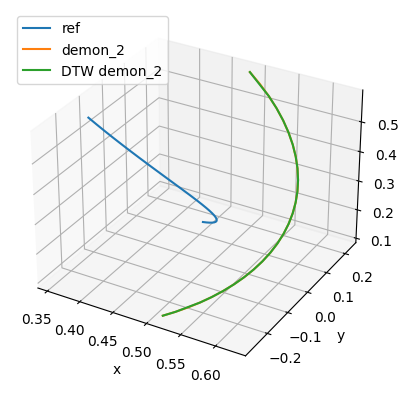

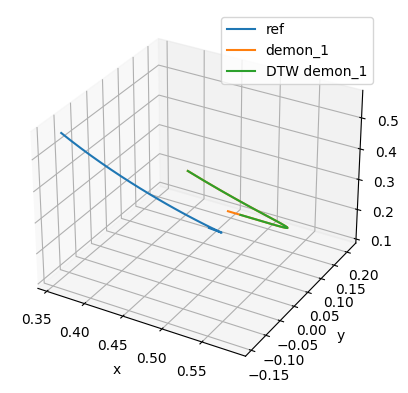

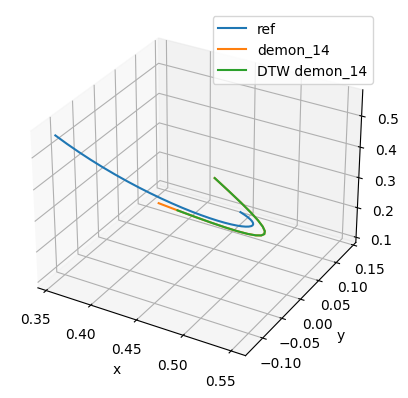

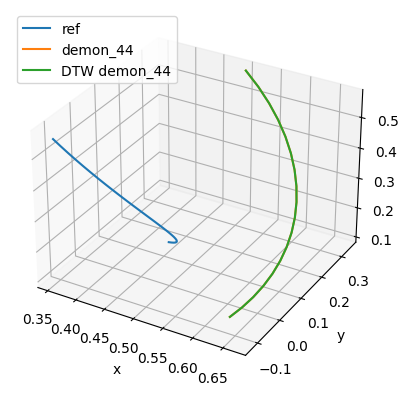

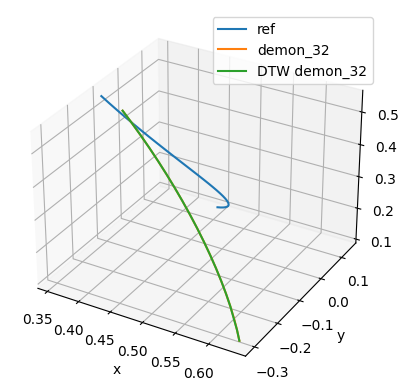

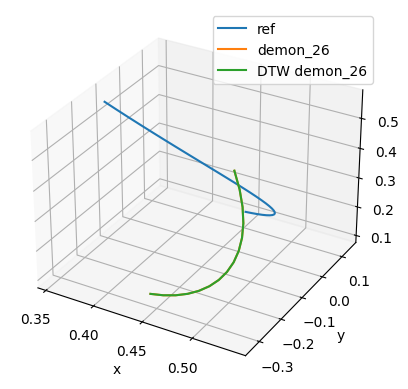

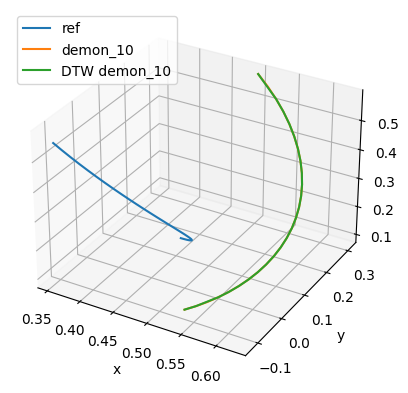

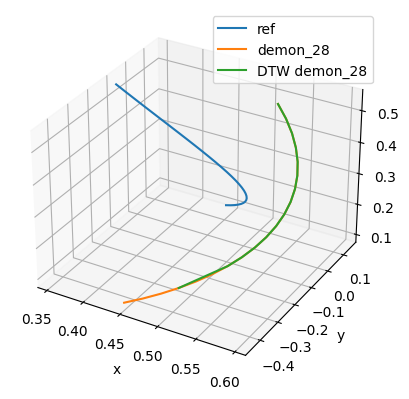

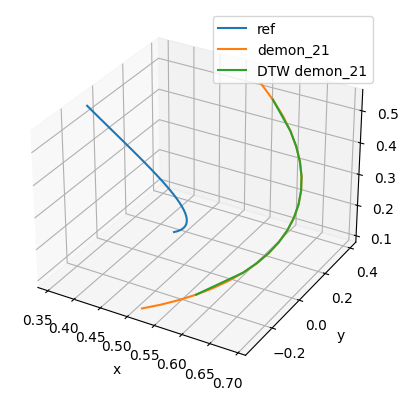

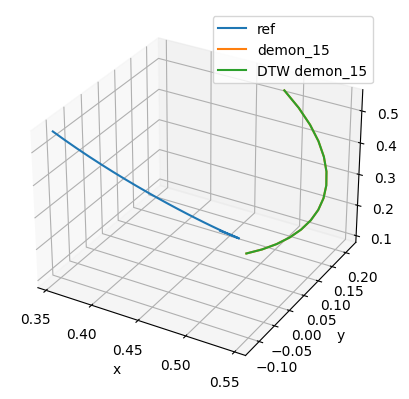

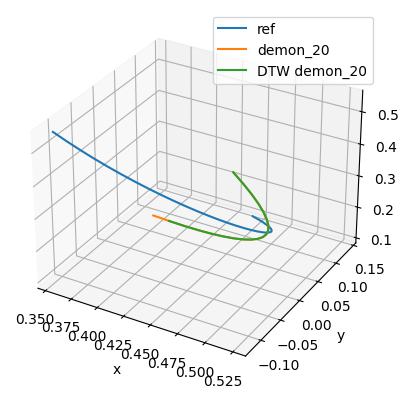

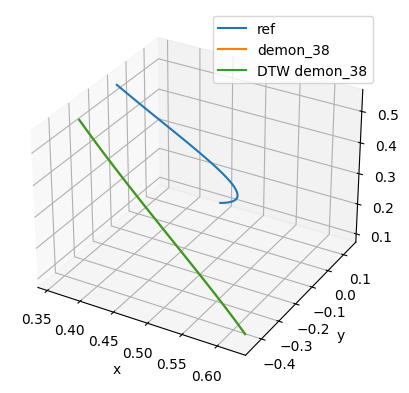

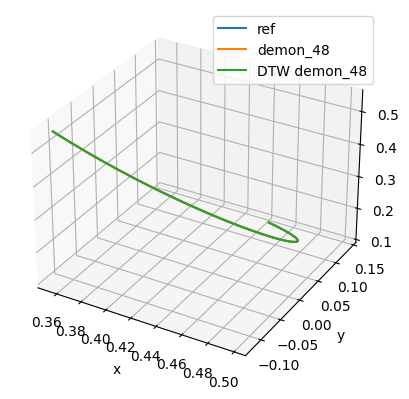

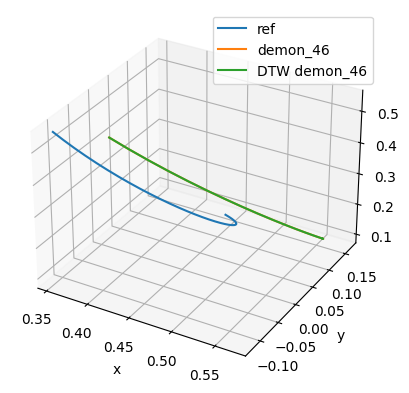

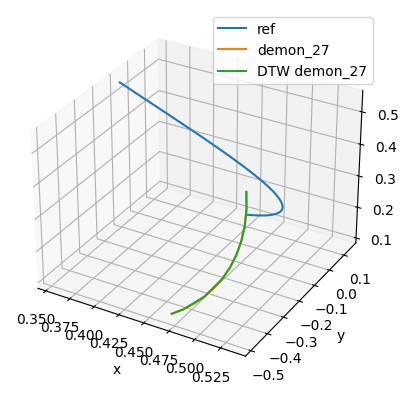

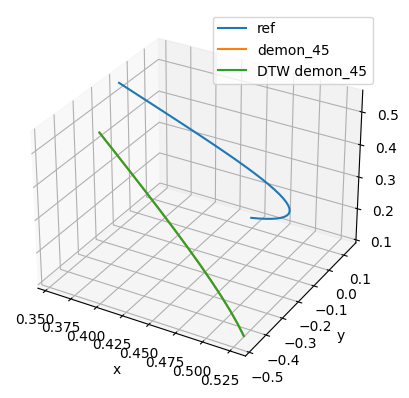

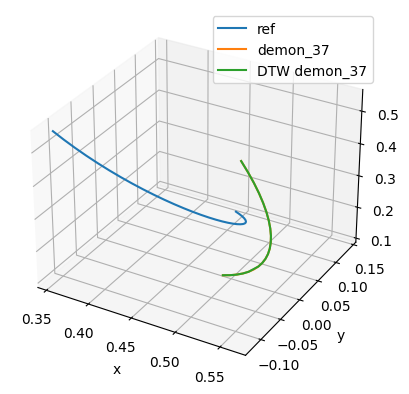

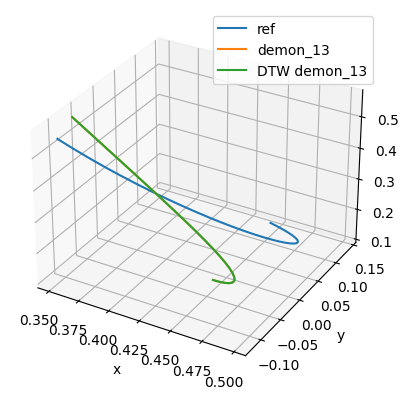

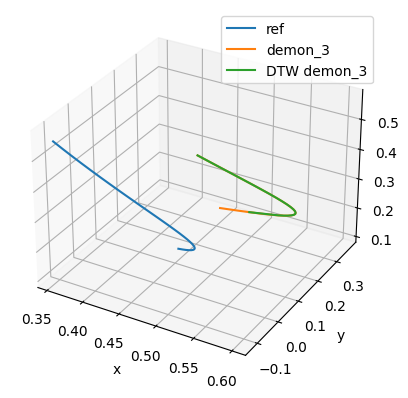

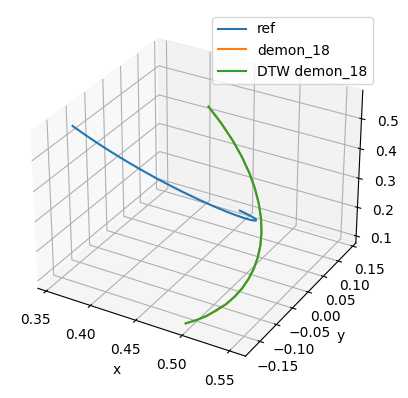

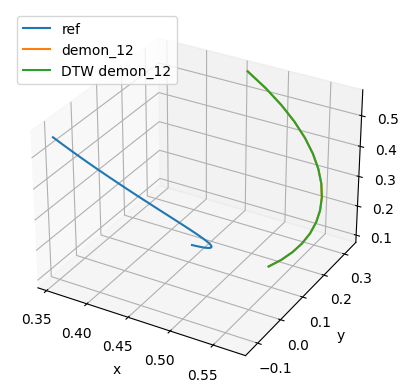

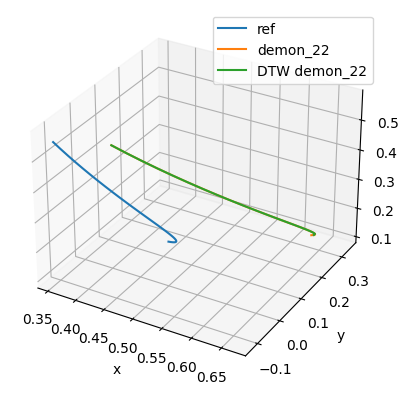

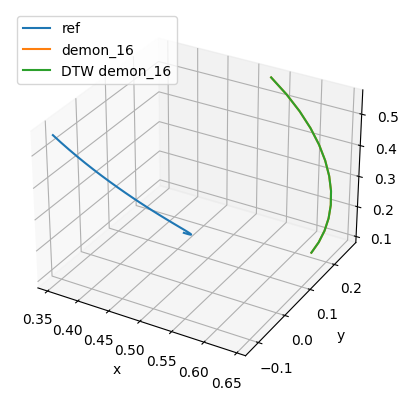

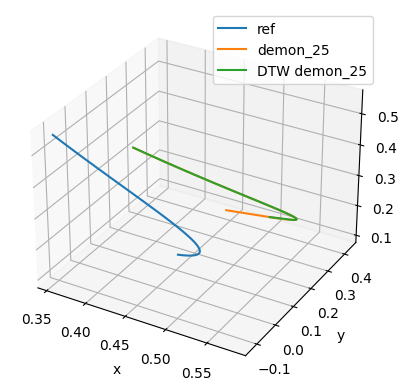

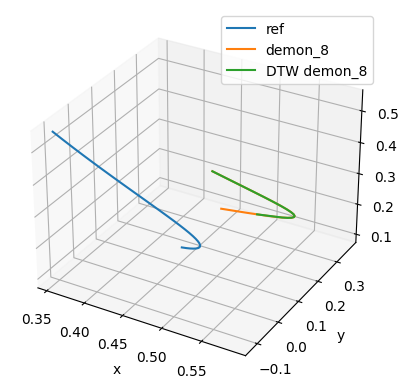

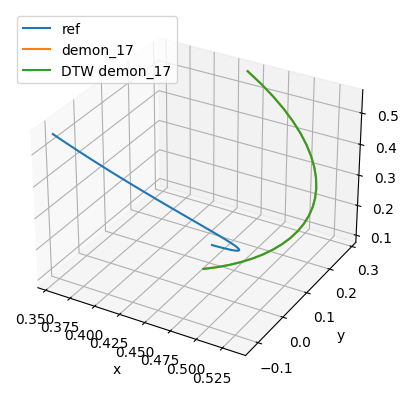

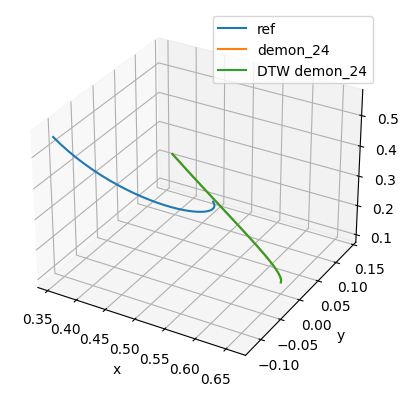

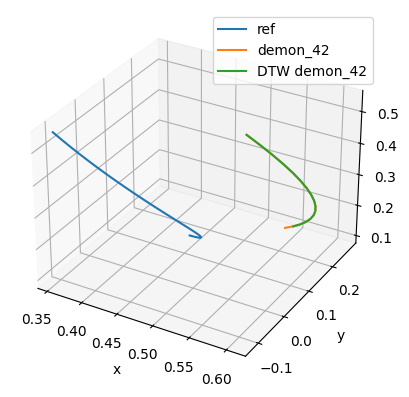

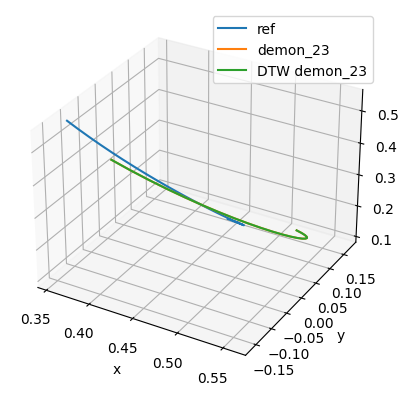

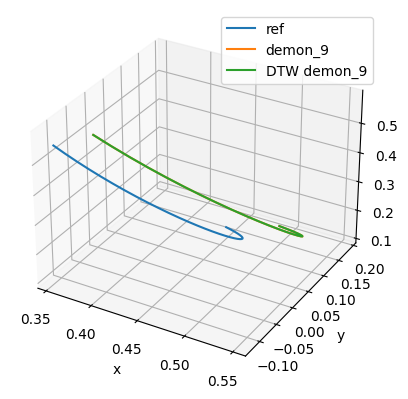

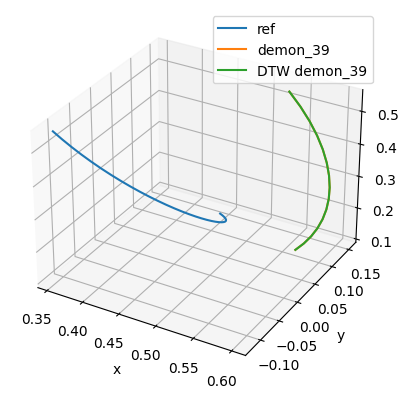

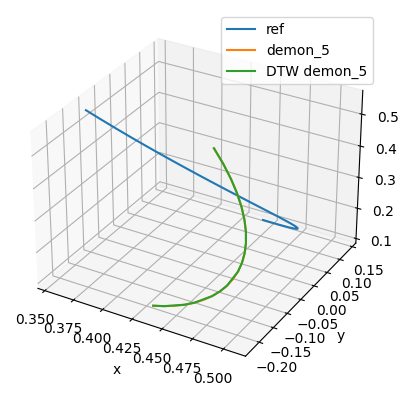

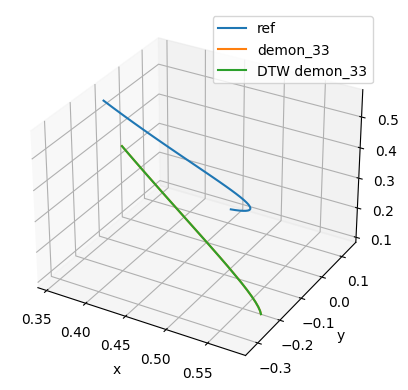

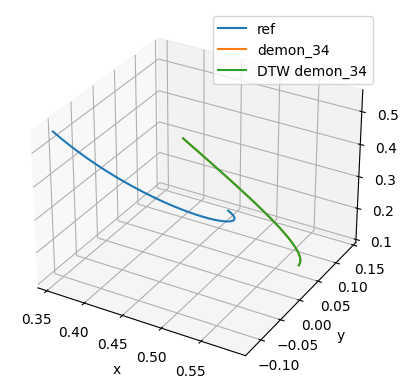

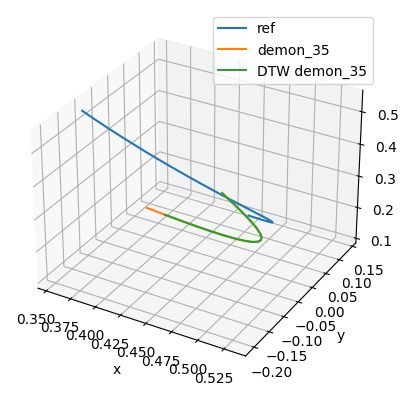

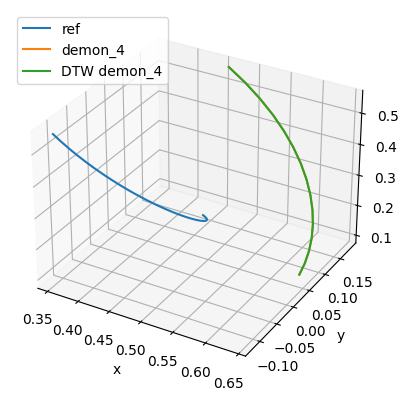

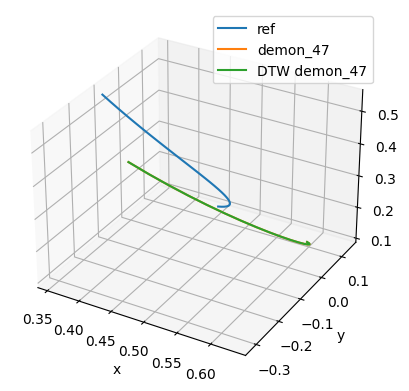

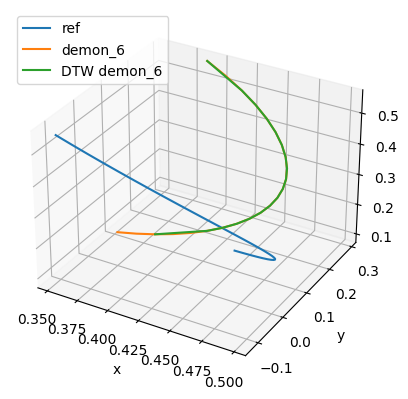

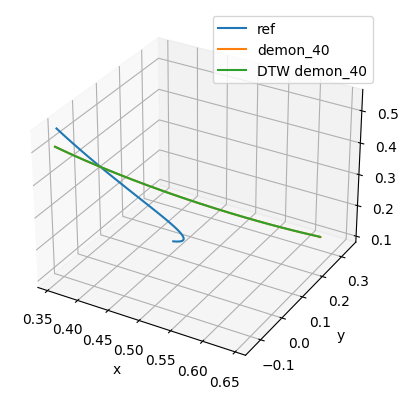

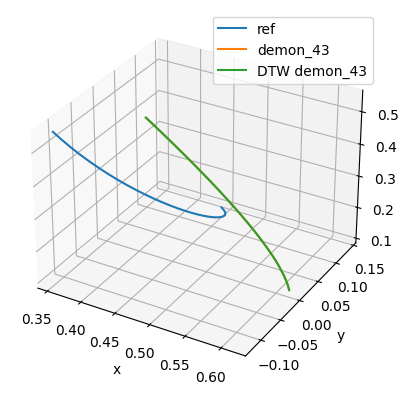

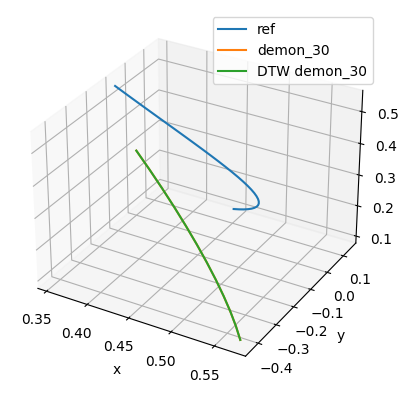

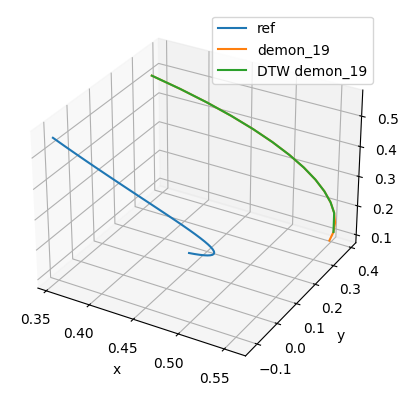

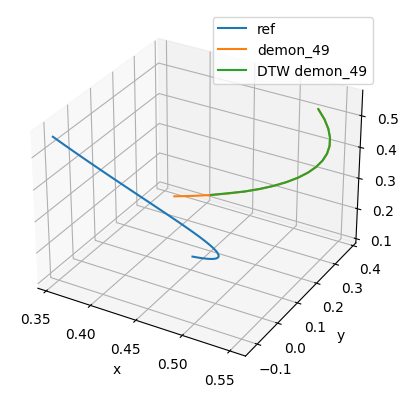

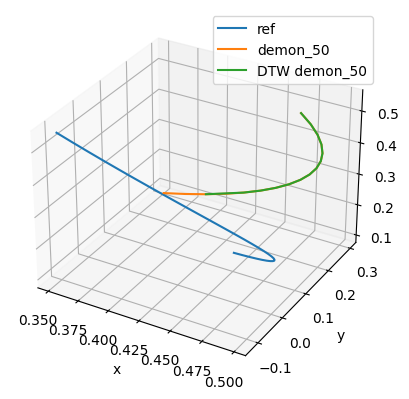

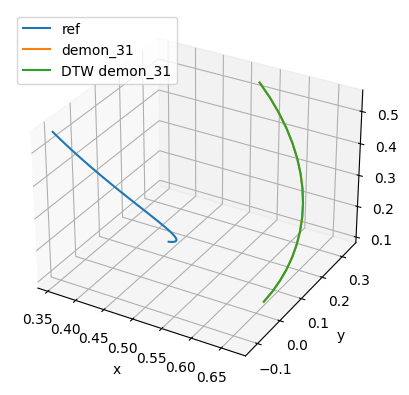

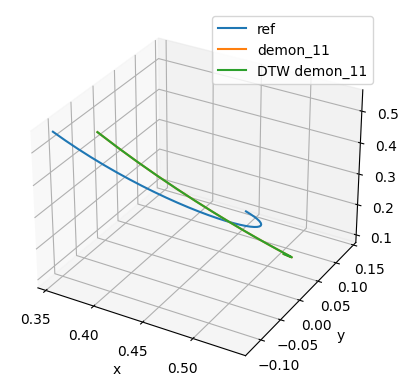

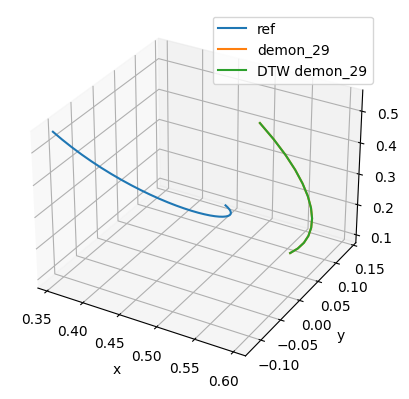

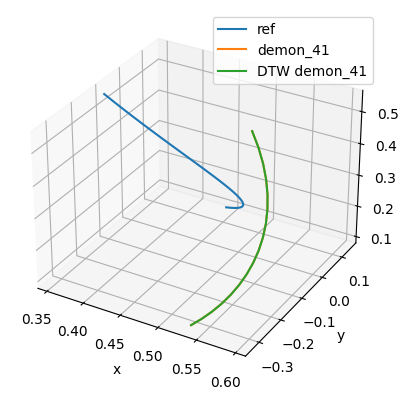

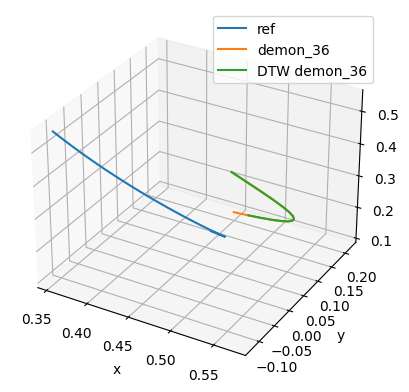

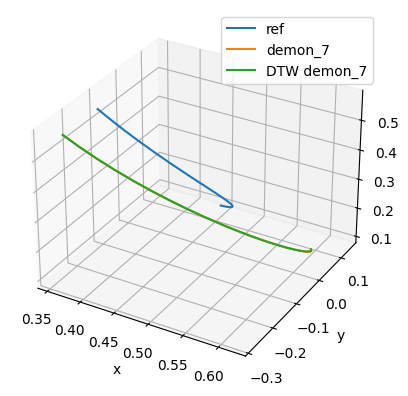

In [ ]:
%matplotlib inline
# %matplotlib qt
from dtw import *

print("Reference Demon:")
ref_arr_Data = np.loadtxt(TPGMM_dir + ref_demon['ref'] + "_sample_Data.txt", delimiter=',')
print(ref_arr_Data.shape)
demons_nums_dtw = []

for d in range(nbdemons):
    
    print("DTWinng..")
    temp_arr_Data = np.loadtxt(TPGMM_dir + demons_nums[d] + "_sample_Data.txt", delimiter=',')
    print(temp_arr_Data.shape)

    DTW = dtw(temp_arr_Data[1:,:].T, ref_arr_Data[1:,:].T)
    wq = warp(DTW, index_reference=False)
    print(wq.shape)
    print(warpArea(DTW))
    print(DTW.distance)
    print(DTW.normalizedDistance)

    # if (DTW.normalizedDistance >= 0.30): continue # Filter out the odd demons
    
    ## Plotting
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.plot(ref_arr_Data[1,:], ref_arr_Data[2,:], ref_arr_Data[3,:], label='ref')
    ax.plot(temp_arr_Data[1,:], temp_arr_Data[2,:], temp_arr_Data[3,:], label='{}'.format(demons_nums[d]))
    ax.plot(temp_arr_Data[1,wq], temp_arr_Data[2,wq], temp_arr_Data[3,wq], label='DTW {}'.format(demons_nums[d]))
    
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ## Saving in .txt
    temp_arr_Data = temp_arr_Data[:,wq]
    temp_arr_Data[0,:] = ref_arr_Data[0,:ref_arr_Data.shape[1]]#-1] # NOTE: It seems that with the update of 'dtw' package, this '-1' here has to be removed

    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_Data.txt", temp_arr_Data, fmt='%.5f')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_Data.txt", 'r') as f: # The 'r' before the directory name is to open the file as read-only
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_Data.txt", 'w') as f:
        f.write(data)
    # Re-shaping the A & b matrices .txt to be of the same shape as the reference Demon (longest or shortest)
    temp_arr_frame1_b = np.loadtxt(TPGMM_dir + demons_nums[d] + "_sample_frame1_b.txt", delimiter=',')
    temp_arr_frame1_A = np.loadtxt(TPGMM_dir + demons_nums[d] + "_sample_frame1_A.txt", delimiter=',')
    temp_arr_frame2_b = np.loadtxt(TPGMM_dir + demons_nums[d] + "_sample_frame2_b.txt", delimiter=',')
    temp_arr_frame2_A = np.loadtxt(TPGMM_dir + demons_nums[d] + "_sample_frame2_A.txt", delimiter=',')
    
    temp_arr_frame1_b = np.ones((ref_arr_Data.shape[0], ref_arr_Data.shape[1])) * temp_arr_frame1_b[:,0].reshape(ref_arr_Data.shape[0], 1)
    temp_arr_frame1_A = np.tile(temp_arr_frame1_A[:4,:4], ref_arr_Data.shape[1])
    temp_arr_frame2_b = np.ones((ref_arr_Data.shape[0], ref_arr_Data.shape[1])) * temp_arr_frame2_b[:,0].reshape(ref_arr_Data.shape[0], 1)
    temp_arr_frame2_A = np.tile(temp_arr_frame2_A[:4,:4], ref_arr_Data.shape[1])

    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame1_b.txt", temp_arr_frame1_b, fmt='%.5f')
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame1_A.txt", temp_arr_frame1_A, fmt='%.5f')
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame2_b.txt", temp_arr_frame2_b, fmt='%.5f')
    np.savetxt(TPGMM_dir + demons_nums[d] + "_sample_frame2_A.txt", temp_arr_frame2_A, fmt='%.5f')

    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_b.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_b.txt", 'w') as f:
        f.write(data)

    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_A.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame1_A.txt", 'w') as f:
        f.write(data)

    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame2_b.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame2_b.txt", 'w') as f:
        f.write(data)

    with open(r"{}".format(TPGMM_dir) + demons_nums[d] + "_sample_frame2_A.txt", 'r') as f:
        data = f.read(); data = data.replace(' ', ',')
    with open(r"{}".format(TPGMM_dir) + demons_nums[d]+ "_sample_frame2_A.txt", 'w') as f:
        f.write(data)

    ## Only for debuggin to check the txt file shape
    print("Debugging")
    temp_arr_Data = np.loadtxt(TPGMM_dir + demons_nums[d] + "_sample_Data.txt", delimiter=',')
    print(temp_arr_Data.shape)
    print("\n")

    demons_nums_dtw.append(demons_nums[d])
    
# Resend the dictionary again after filtering the Demons according to DTW (i.e. keeping the most similar ones)
ref_demon["demons_nums"] = demons_nums_dtw
ref_demon["nbDemons"] = len(ref_demon["demons_nums"])
print("Reference Demon:")
print(ref_demon)
with open('/home/erl/Multicobot-UR10/src/tp_gmm/scripts/demons_info2.pkl', 'wb') as fp:
    pickle.dump(ref_demon, fp)    


In [6]:
# print(temp_arr_frame1_b.shape)
# print(temp_arr_frame1_A.shape)
# print(temp_arr_frame2_b.shape)
# print(temp_arr_frame2_A.shape)
# print(temp_arr_frame2_A[:4,:4].shape)